# Decompose with simple Interpolation

In [18]:
# imports

from importlib import reload

from functools import partial

import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from datetime import datetime, time
import random 
import torch

import pandas
import seaborn as sns

from oceancolor.utils import plotting 
from oceancolor.iop import cross

from ihop import io as ihop_io
from ihop.iops import decompose 
from ihop.iops import io as iops_io
from ihop.emulators import io as emu_io
from ihop.inference import io as inf_io
from ihop.training_sets import load_rs


In [2]:
%matplotlib ipympl

# Load up Loisel+2023

In [7]:
hidden_list=[512, 512, 512, 256]
dataset='L23' 
chop_burn=-3000 
abs_sig=None # Noiseless
perc=None
X=4 
Y=0 
#in_idx:int=2663
in_idx:int=0
idx = 170
decomps=('nmf', 'nmf')
Ncomps = (2,2)

In [8]:
# Load
edict = emu_io.set_emulator_dict(dataset, decomps, Ncomps, 'Rrs',
    'dense', hidden_list=hidden_list, include_chl=True, X=X, Y=Y)

ab, Chl, Rs, d_a, d_bb = ihop_io.load_l23_full(decomps, Ncomps)

emulator, e_file = emu_io.load_emulator_from_dict(edict)

Loading... 
Loading decomps from /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_a_N02.npz and /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_bb_N02.npz
Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_22_chl_Rrs_dense_512_512_512_256.pth


/home/xavier/miniconda3/envs/os_11/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Load NMF on $a_{\rm ph}$

In [11]:
aph_file = iops_io.loisel23_filename('nmf', 'aph', 2, 4, 0)

In [12]:
d_aph = np.load(aph_file)
d_aph

NpzFile '/home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_aph_N02.npz' with keys: M, coeff, spec, mask, err...

In [16]:
d_aph['M'].shape

(2, 81)

# Fit

## Prep

In [14]:
def a_func(wave, Adg, Sdg, H1, H2, W1=None, W2=None):
    # CDOM/detritus
    a_dg = Adg * np.exp(-Sdg*(wave-440)) 
    # a_ph
    a_ph = H1*W1 + H2*W2
    #
    return a_dg + a_ph

In [17]:
partial_func = partial(a_func, W1=d_aph['M'][0], W2=d_aph['M'][1])

## Do one

In [20]:
idx = 100

In [24]:
ans, cov = curve_fit(partial_func, d_a['wave'], d_a['spec'][idx],
                    p0=[0.01, 0.01, 0.05, 0.05])

In [25]:
ans

array([0.00981901, 0.01054323, 0.08887535, 0.14149566])

In [29]:
recon = a_func(d_a['wave'], *ans, W1=d_aph['M'][0], W2=d_aph['M'][1])

# Plot

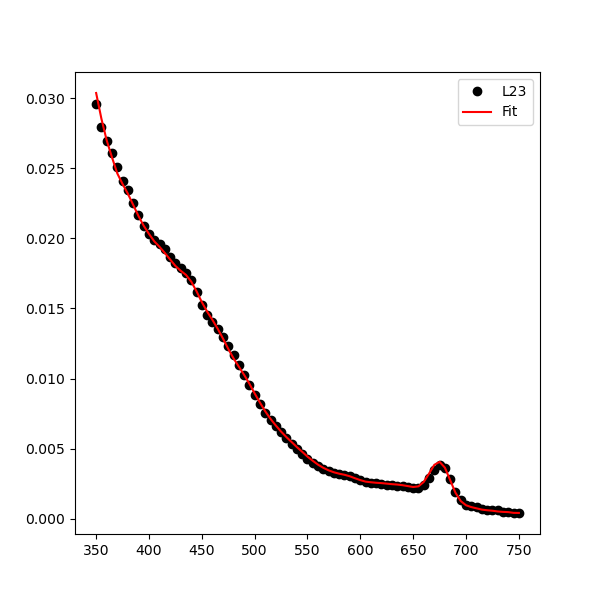

In [30]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
#
ax.plot(d_a['wave'], d_a['spec'][idx], 'ko', label='L23', zorder=1)
ax.plot(d_a['wave'], recon, 'r-', label='Fit')
#
ax.legend()
#
plt.show()